Checking the data, to get an idea of what columns etc.

In [150]:
import pandas as pd
acc = pd.read_csv("/Users/kunal/Code/Biometric Assignment/data/sample_data/2_PocketPhone_Accelerometer_(Samsung_S6).csv")
gyr = pd.read_csv("/Users/kunal/Code/Biometric Assignment/data/sample_data/2_PocketPhone_Gyroscope_(Samsung_S6).csv")
acc.head(), gyr.head()

(   EID    Xvalue     Yvalue    Zvalue                     time
 0    0  1.978808  -1.114501  3.514688  2017-04-17 14:44:43.026
 1    1  0.810437  -2.832341  2.801216  2017-04-17 14:44:43.036
 2    2 -0.252588  -5.337873  2.322376  2017-04-17 14:44:43.045
 3    3 -1.994370  -8.580819  0.926556  2017-04-17 14:44:43.057
 4    4 -3.323152 -11.498154 -0.196325  2017-04-17 14:44:43.066,
    EID    Xvalue    Yvalue    Zvalue                     time
 0    0  0.579504 -0.647681  0.233293  2017-04-17 14:44:43.026
 1    1  1.075917 -1.181378  0.243946  2017-04-17 14:44:43.036
 2    2  1.538242 -1.643703  0.274838  2017-04-17 14:44:43.045
 3    3  1.940912 -1.842908  0.297209  2017-04-17 14:44:43.057
 4    4  2.179531 -1.902562  0.373908  2017-04-17 14:44:43.066)

DEFINING Data Paths

In [151]:
DATA_ROOT = "data"
RAW_DIR = f"{DATA_ROOT}/sample_data"
PROCESSED_DIR = f"{DATA_ROOT}/processed_data"
OUT_X = f"{DATA_ROOT}/X.npy"
OUT_y = f"{DATA_ROOT}/y.npy"
OUT_X_CLEAN = f"{DATA_ROOT}/X_clean.npy"

Combining data from the gyroscope and the accelerometer to create a single 6 channel data stream

In [119]:
import os, re, pathlib as pl
import pandas as pd
import numpy as np

loading sensor data from the csv files

In [152]:
#function loads sensor data from a CSV, converts it to a standard 'time', 'x', 'y', 'z' format with correct data types, and cleans the resulting DataFrame.
def load_sensor_csv(path, time_col="time", x_col="X", y_col="Y", z_col="Z"):
    df = pd.read_csv(path, usecols=[time_col, x_col, y_col, z_col]).copy()
    df = df.rename(columns={time_col: "time", x_col: "x", y_col: "y", z_col: "z"})
    df["time"] = pd.to_datetime(df["time"], errors="coerce")
   

    df = df.dropna(subset=["time"]).sort_values("time")
    df[["x","y","z"]] = df[["x","y","z"]].astype(float)
    return df

Resampling of data done below. This is to ensure that all 6 channels have the same reading at the same time.

In [153]:
def to_100hz(df):
    s = df.set_index('time').sort_index()
    # collapse duplicate timestamps (take mean), resample to 10 ms, interpolate tiny gaps
    s = s.groupby(level=0).mean()
    s = s.resample('10ms').mean().interpolate(limit_direction='both')
    return s

In [154]:
def merge_pair(acc_path, gyr_path, out_dir):
    acc = load_sensor_csv(acc_path)
    gyr = load_sensor_csv(gyr_path)

    acc100 = to_100hz(acc).add_prefix('acc_')
    gyr100 = to_100hz(gyr).add_prefix('gyr_')

    # keep only overlap
    start = max(acc100.index.min(), gyr100.index.min())
    end   = min(acc100.index.max(), gyr100.index.max())
    if not (start < end):
        raise ValueError(f"No overlap: {acc_path} | {gyr_path}")

    idx = pd.date_range(start, end, freq='10ms')
    acc100 = acc100.reindex(idx).interpolate(limit_direction='both')
    gyr100 = gyr100.reindex(idx).interpolate(limit_direction='both')

    merged = pd.concat([acc100, gyr100], axis=1).dropna()
    merged = merged.reset_index().rename(columns={'index':'time'})

    # output name: replace 'Accelerometer' → '6D' in the accelerometer filename
    base = pl.Path(acc_path).name
    out_name = re.sub(r'(?i)Accelerometer', '6D', base)
    out_path = pl.Path(out_dir) / out_name
    merged.to_csv(out_path, index=False)
    return str(out_path), len(merged)

In [155]:
#below we check if the accelerometer files has a corresponding gyroscope file with the same name. if so put them as a paired tuple 
pairs = []
for acc_path in acc_files:
    gyr_path = str(acc_path).replace("Accelerometer", "Gyroscope")
    if pl.Path(gyr_path).exists():
        pairs.append((str(acc_path), gyr_path))
    else:
        print("Skipping (no gyro found):", acc_path)

print(f"Found {len(pairs)} pairs")

Found 10 pairs


In [ ]:
ok, fail = 0, 0
for acc_path, gyr_path in pairs:
    try:
        out_path, n = merge_pair(acc_path, gyr_path, PROCESSED_DIR)
        ok += 1
        print(f"OK: {pl.Path(acc_path).name} + {pl.Path(gyr_path).name} -> {pl.Path(out_path).name} ({n} rows)")
    except Exception as e:
        fail += 1
        print(f"FAIL: {pl.Path(acc_path).name} | {pl.Path(gyr_path).name} :: {e}")

print(f"Done. success={ok}, failed={fail}")

After Comnbining the files into a single processed data file with 6 channels. we proceed to window it.

In [158]:
PROCESSED_DIR = "/Users/kunal/Code/Biometric Assignment/data/processed_data"
OUT_X = "/Users/kunal/Code/Biometric Assignment/data/X.npy"
OUT_y = "/Users/kunal/Code/Biometric Assignment/data/y.npy"

In [159]:
import pathlib as pl
import numpy as np
import pandas as pd

def subject_id_from_name(name):
    # e.g., "2_PocketPhone_6D_(Samsung_S6).csv" -> 2
    return int(name.split("_", 1)[0])

WIN = 500   # 5s * 100Hz
HOP = 250   # 50% overlap

Xs, ys = [], []

for csv_path in sorted(pl.Path(PROCESSED_DIR).glob("*.csv")):
    df = pd.read_csv(csv_path)
    X6 = df[["acc_x","acc_y","acc_z","gyr_x","gyr_y","gyr_z"]].to_numpy(dtype=float)

    # make windows
    for i in range(0, len(X6) - WIN + 1, HOP):
        win = X6[i:i+WIN]
        Xs.append(win)
        ys.append(subject_id_from_name(csv_path.name))

X = np.stack(Xs) if Xs else np.empty((0, WIN, 6))
y = np.array(ys, dtype=int)

np.save(OUT_X, X)
np.save(OUT_y, y)

print("X shape:", X.shape)  # (n_windows, 500, 6)
print("y shape:", y.shape)  # (n_windows,)
print("Subjects in y:", sorted(set(y.tolist())))
print("Saved to:", OUT_X, "and", OUT_y)

X shape: (14588, 500, 6)
y shape: (14588,)
Subjects in y: [2, 13, 23, 24, 49, 52, 55, 70, 78, 112]
Saved to: /Users/kunal/Code/Biometric Assignment/data/X.npy and /Users/kunal/Code/Biometric Assignment/data/y.npy


Data Cleaning -  using Z score clipping(outliers z>3 removed) and moving average smoothing.

In [160]:
import pandas as pd
import numpy as np

def clean_window(window, z_thresh=3, k=5):
    """
    window : (T, C) array (e.g. 500 x 6)
    z_thresh : z-score cutoff
    k : moving average window size
    """
    # z-score capping
    mean = window.mean(axis=0, keepdims=True)
    std  = window.std(axis=0, keepdims=True) + 1e-8
    z = (window - mean) / std
    window = np.clip(z, -z_thresh, z_thresh) * std + mean
    
    # simple moving average smoothing
    df = pd.DataFrame(window)
    window_smoothed = df.rolling(window=k, center=True, min_periods=1).mean().to_numpy()
    return window_smoothed

In [161]:
X = np.load("/Users/kunal/Code/Biometric Assignment/data/X.npy")
y = np.load("/Users/kunal/Code/Biometric Assignment/data/y.npy")

# Apply cleaning to each window
X_clean = np.array([clean_window(w) for w in X])

# Save for re-use
np.save("/Users/kunal/Code/Biometric Assignment/data/X_clean.npy", X_clean)
print("Cleaned windows saved -> X_clean.npy")

Cleaned windows saved -> X_clean.npy


In [162]:
X_PATH = "/Users/kunal/Code/Biometric Assignment/data/X_clean.npy"
Y_PATH = "/Users/kunal/Code/Biometric Assignment/data/y.npy"

In [163]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [164]:
X = np.load(X_PATH) 
y = np.load(Y_PATH)

Below we do Feature extraction where we provide around 16 features for each column . 16*6 leading up to 96 features in total.

In [165]:
def to_features_enhanced(X):
    """
    Extract comprehensive features from windowed data
    X: (N, T, C) where T=500, C=6
    Returns: (N, F) where F is total number of features
    """
    from scipy.stats import skew, kurtosis
    
    # Statistical features
    mean = X.mean(axis=1)                    # (N, 6)
    std = X.std(axis=1)                      # (N, 6)
    var = X.var(axis=1)                      # (N, 6)
    median = np.median(X, axis=1)            # (N, 6)
    q75 = np.percentile(X, 75, axis=1)       # (N, 6)
    q25 = np.percentile(X, 25, axis=1)       # (N, 6)
    iqr = q75 - q25                          # (N, 6)
    min_val = X.min(axis=1)                  # (N, 6)
    max_val = X.max(axis=1)                  # (N, 6)
    range_val = max_val - min_val            # (N, 6)
    
    # Energy and signal characteristics
    energy = (X**2).mean(axis=1)             # (N, 6)
    rms = np.sqrt(energy)                    # (N, 6)
    
    # Zero crossing rate (count sign changes)
    zero_crossings = ((X[:, :-1] * X[:, 1:]) < 0).sum(axis=1)  # (N, 6)
    
    # Mean absolute deviation
    mad = np.abs(X - mean[:, np.newaxis, :]).mean(axis=1)  # (N, 6)
    
    # Higher order moments
    skewness = skew(X, axis=1)               # (N, 6)
    kurt = kurtosis(X, axis=1)               # (N, 6)
    
    # Frequency domain features (FFT)
    fft_vals = np.fft.rfft(X, axis=1)
    fft_mag = np.abs(fft_vals)
    
    # Dominant frequency index
    dominant_freq_idx = fft_mag.argmax(axis=1)  # (N, 6)
    
    # Spectral energy
    spectral_energy = (fft_mag**2).sum(axis=1)  # (N, 6)
    
    # Concatenate all features
    feats = np.concatenate([
        mean, std, var, median, iqr, min_val, max_val, range_val,
        energy, rms, zero_crossings, mad, skewness, kurt,
        dominant_freq_idx, spectral_energy
    ], axis=1)
    
    return feats  # (N, 96) = 16 feature types × 6 channels

# Extract enhanced features
print("Extracting enhanced features...")
Xf_enhanced = to_features_enhanced(X)
print(f"Feature matrix shape: {Xf_enhanced.shape}")

Extracting enhanced features...
Feature matrix shape: (14588, 96)


In [166]:
Xf = to_features_enhanced(X)

For feature reduction we use SelectKBest (ANOVA F-value) to choose the top 10 features

In [167]:
from sklearn.feature_selection import SelectKBest, f_classif

# keep the 10 best features based on ANOVA F-test
selector = SelectKBest(score_func=f_classif, k=10)
Xf_selected = selector.fit_transform(Xf, y)

# optional: see which features were chosen
mask = selector.get_support()
selected_indices = np.where(mask)[0]
print("Selected feature indices:", selected_indices.tolist())
print("Reduced feature matrix shape:", Xf_selected.shape)

Selected feature indices: [1, 2, 19, 20, 32, 38, 50, 56, 59, 92]
Reduced feature matrix shape: (14588, 10)


/Users/kunal/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [60 63 84 87] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/kunal/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Here we split train and test data

In [168]:
Xtr, Xte, ytr, yte = train_test_split(Xf, y, test_size=0.2, stratify=y, random_state=0)


Scaling features using Standard Scaler


In [169]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
Xtr_s = scaler.fit_transform(Xtr)   # fit on train
Xte_s = scaler.transform(Xte)       # transform test

In [170]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


For Kfold cross validation

In [175]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
accs = []
reports = []
cms = []
loss_curves = []  # Added to track training loss curves for each fold

for fold, (train_idx, test_idx) in enumerate(kf.split(Xf_selected, y)):
    Xtr, Xte = Xf_selected[train_idx], Xf_selected[test_idx]
    ytr, yte = y[train_idx], y[test_idx]
    
    scaler = StandardScaler()
    Xtr_s = scaler.fit_transform(Xtr)
    Xte_s = scaler.transform(Xte)
    
    mlp = MLPClassifier(hidden_layer_sizes=(5, 5), activation="relu", solver="adam", max_iter=500, random_state=0)
    mlp.fit(Xtr_s, ytr)
    yp = mlp.predict(Xte_s)
    
    acc = accuracy_score(yte, yp)
    accs.append(acc)
    reports.append(classification_report(yte, yp, output_dict=True))
    cms.append(confusion_matrix(yte, yp))
    loss_curves.append(mlp.loss_curve_)  # Added to store the loss curve for this fold
    
    print(f"Fold {fold+1} accuracy: {acc:.4f}")

print(f"\nMean accuracy over {kf.get_n_splits()} folds: {np.mean(accs):.4f}")

Fold 1 accuracy: 0.9688
Fold 2 accuracy: 0.9743


/Users/kunal/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 3 accuracy: 0.9774
Fold 4 accuracy: 0.9647
Fold 5 accuracy: 0.9691

Mean accuracy over 5 folds: 0.9709


/Users/kunal/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


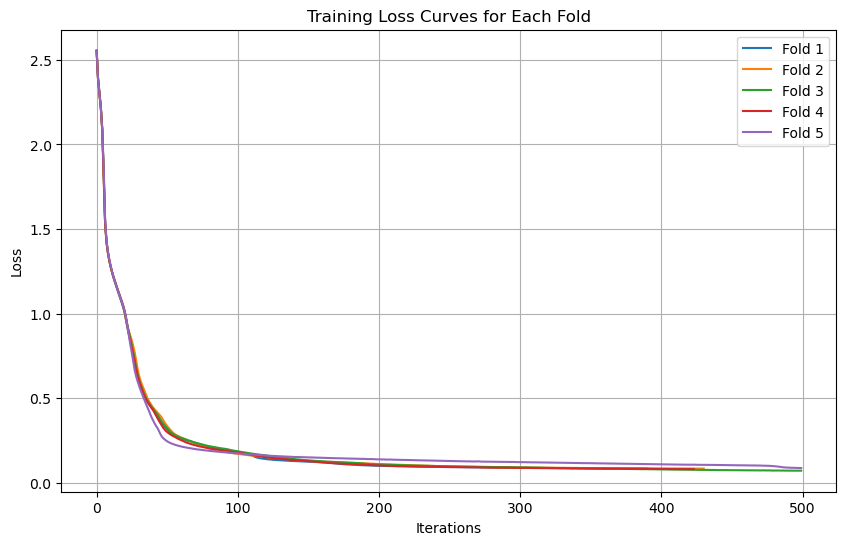

In [176]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for i, curve in enumerate(loss_curves):
    plt.plot(curve, label=f'Fold {i+1}')

plt.title('Training Loss Curves for Each Fold')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [172]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

# After running K-Fold, suppose you have:
# accs: list of validation accuracies for each fold
# reports: list of classification_report dicts for each fold
# cms: list of confusion matrices for each fold
# histories: list of dicts with 'train_acc', 'val_acc', 'train_loss', 'val_loss' per epoch for each fold (if you record these during training)

# 1. Average accuracy
mean_acc = np.mean(accs)
std_acc = np.std(accs)
print(f"Mean Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")

# 2. Precision, Recall, F1 (macro/weighted/class-wise)
precisions, recalls, f1s = [], [], []
for rep in reports:
    precisions.append([rep[str(cls)]['precision'] for cls in rep if cls.isdigit()])
    recalls.append([rep[str(cls)]['recall'] for cls in rep if cls.isdigit()])
    f1s.append([rep[str(cls)]['f1-score'] for cls in rep if cls.isdigit()])

precisions = np.array(precisions)
recalls = np.array(recalls)
f1s = np.array(f1s)

print("Class-wise Precision (mean ± std):", np.mean(precisions, axis=0), np.std(precisions, axis=0))
print("Class-wise Recall (mean ± std):", np.mean(recalls, axis=0), np.std(recalls, axis=0))
print("Class-wise F1-score (mean ± std):", np.mean(f1s, axis=0), np.std(f1s, axis=0))

# Macro/weighted averages
macro_f1 = [rep['macro avg']['f1-score'] for rep in reports]
weighted_f1 = [rep['weighted avg']['f1-score'] for rep in reports]
print(f"Macro F1-score: {np.mean(macro_f1):.4f} ± {np.std(macro_f1):.4f}")
print(f"Weighted F1-score: {np.mean(weighted_f1):.4f} ± {np.std(weighted_f1):.4f}")

# 3. Confusion Matrix (mean over folds)
mean_cm = np.mean(np.array(cms), axis=0)
print("Mean Confusion Matrix over folds:\n", mean_cm.astype(int))

# 4. Plots: Training/Validation Accuracy and Loss over epochs
# histories: list of dicts with keys 'train_acc', 'val_acc', 'train_loss', 'val_loss'


Mean Accuracy: 0.9709 ± 0.0045
Class-wise Precision (mean ± std): [0.94486483 0.94534444 0.98489993 0.96759565 0.99566799 0.92609132
 0.99106004 0.90213317 0.99663866 0.92240543] [0.02852102 0.01947376 0.01433257 0.02676856 0.00205015 0.03315933
 0.00974126 0.06188656 0.00672269 0.04141059]
Class-wise Recall (mean ± std): [0.97004658 0.91920007 0.95539621 0.96610527 0.99136    0.92700665
 0.99177967 0.91785858 0.99143826 0.94949647] [0.01079272 0.02421689 0.02137277 0.03205021 0.00222854 0.03501214
 0.00368456 0.06850421 0.00540568 0.02650774]
Class-wise F1-score (mean ± std): [0.95710871 0.93164617 0.96974243 0.96606267 0.99350577 0.92591462
 0.99139403 0.90551452 0.99399841 0.93465228] [0.01747809 0.00914928 0.0127532  0.01150996 0.00102849 0.02409196
 0.00537728 0.02026893 0.00207939 0.0148985 ]
Macro F1-score: 0.9570 ± 0.0069
Weighted F1-score: 0.9710 ± 0.0046
Mean Confusion Matrix over folds:
 [[ 155    1    0    0    2    0    0    1    0    0]
 [   4  136    0    0    2    0    

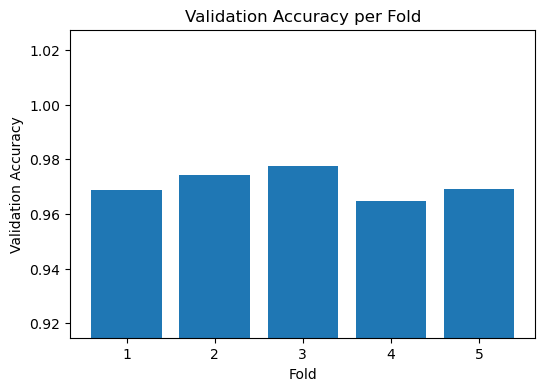

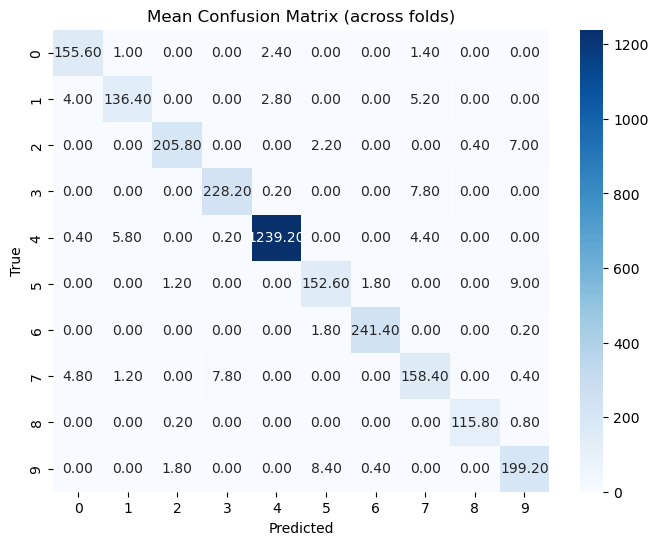

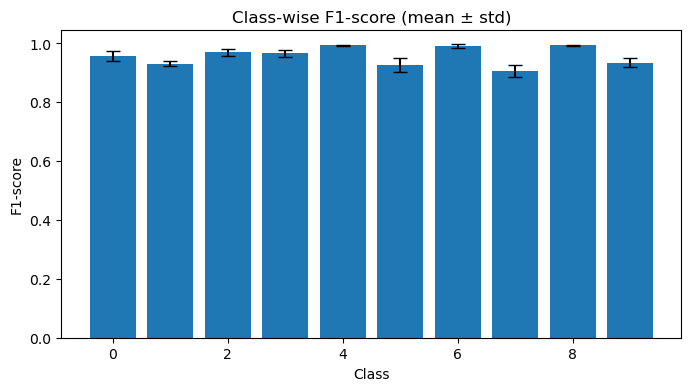

In [173]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
# Plot accuracy for each fold with zoomed y-axis
plt.figure(figsize=(6,4))
plt.bar(range(1, len(accs)+1), accs)
plt.xlabel('Fold')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy per Fold')
plt.ylim(min(accs)-0.05, max(accs)+0.05)  # Zoom to accuracy range with small margin
plt.show()

# Plot mean confusion matrix (fix: use fmt='.2f' for float values)
plt.figure(figsize=(8,6))
sns.heatmap(mean_cm, annot=True, fmt='.2f', cmap='Blues')
plt.title('Mean Confusion Matrix (across folds)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Plot class-wise F1-score mean and std
f1_mean = np.mean(f1s, axis=0)
f1_std = np.std(f1s, axis=0)
plt.figure(figsize=(8,4))
plt.bar(range(len(f1_mean)), f1_mean, yerr=f1_std, capsize=5)
plt.xlabel('Class')
plt.ylabel('F1-score')
plt.title('Class-wise F1-score (mean ± std)')
plt.show()

LSTM

In [179]:
# Block 1: Imports & setup
import os, random, numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix
)
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, utils

# Reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

In [180]:
# Block 2: Load data & scale
X = np.load("data/X_clean.npy")  # expected: (N, T, 6)
y = np.load("data/y.npy")        # expected: (N,)

print("X shape:", X.shape, "y shape:", y.shape, "unique classes:", np.unique(y))


X shape: (14588, 500, 6) y shape: (14588,) unique classes: [  2  13  23  24  49  52  55  70  78 112]


In [187]:
# Inspect labels first (optional but helpful)
print("y shape:", y.shape, "dtype:", y.dtype)
print("unique labels (first 20):", np.unique(y)[:20])
print("min/max label:", np.min(y), np.max(y))

# Flatten y if needed (e.g., shape (N,1) -> (N,))
y_flat = np.ravel(y)

y shape: (14588,) dtype: int64
unique labels (first 20): [  2  13  23  24  49  52  55  70  78 112]
min/max label: 2 112


In [188]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_idx = le.fit_transform(y_flat)          # now in 0..K-1
num_classes = len(le.classes_)            # correct K

# One-hot for Keras
from tensorflow.keras import utils
y_cat = utils.to_categorical(y_idx, num_classes=num_classes)

# (Optional) keep a mapping to go back from indices to original labels
index_to_label = {i: lab for i, lab in enumerate(le.classes_)}
label_to_index = {lab: i for i, lab in enumerate(le.classes_)}
print(f"{num_classes} classes remapped to 0..{num_classes-1}")


10 classes remapped to 0..9


In [190]:
N, T, F = X.shape
scaler = StandardScaler()
X_2d = X.reshape(-1, F)              # (N*T, 6)
X_2d_scaled = scaler.fit_transform(X_2d)
X_scaled = X_2d_scaled.reshape(N, T, F)
num_classes = len(np.unique(y))

# One-hot for Keras
y_cat = utils.to_categorical(y_idx, num_classes=num_classes)


In [191]:
# Block 3: Model factory (within assignment constraints)
def make_lstm_model(timesteps, features, num_classes, lstm_layers=3, units=6, dropout=0.2):
    """
    lstm_layers: 1..5
    units: ≤6 per assignment
    """
    assert 1 <= lstm_layers <= 5, "lstm_layers must be between 1 and 5"
    assert units <= 6, "units must be <= 6"

    inputs = layers.Input(shape=(timesteps, features))
    x = inputs
    for i in range(lstm_layers):
        # return_sequences=True for all but last layer
        rs = i < (lstm_layers - 1)
        x = layers.LSTM(units, return_sequences=rs)(x)
        x = layers.Dropout(dropout)(x)

    # Classification head
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = models.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

# Quick summary
tmp_model = make_lstm_model(T, F, num_classes, lstm_layers=3, units=6, dropout=0.2)
tmp_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 500, 6)]          0         
                                                                 
 lstm_56 (LSTM)              (None, 500, 6)            312       
                                                                 
 dropout_6 (Dropout)         (None, 500, 6)            0         
                                                                 
 lstm_57 (LSTM)              (None, 500, 6)            312       
                                                                 
 dropout_7 (Dropout)         (None, 500, 6)            0         
                                                                 
 lstm_58 (LSTM)              (None, 6)                 312       
                                                                 
 dropout_8 (Dropout)         (None, 6)                 0   

In [194]:
from sklearn.preprocessing import LabelEncoder
# y may be shape (N,1); flatten to (N,)
y_flat = np.ravel(y)
le = LabelEncoder()
y_idx = le.fit_transform(y_flat)       # now 0..K-1
num_classes = len(le.classes_)
print("remapped classes:", num_classes)

remapped classes: 10


In [196]:
# Block 4 (fixed): Stratified K-Fold training with y_idx throughout
K = 5
EPOCHS = 30
BATCH_SIZE = 64
PATIENCE = 6

skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=SEED)

histories = []
oof_true = []
oof_pred = []
oof_pred_proba = []

for fold, (tr_idx, va_idx) in enumerate(skf.split(X_scaled, y_idx), 1):
    print(f"\n=== Fold {fold}/{K} ===")
    X_tr, X_va = X_scaled[tr_idx], X_scaled[va_idx]

    # One-hot using the REMAPPED indices
    y_tr = utils.to_categorical(y_idx[tr_idx], num_classes=num_classes)
    y_va = utils.to_categorical(y_idx[va_idx], num_classes=num_classes)

    # Class weights must be keyed 0..num_classes-1
    cw_vals = class_weight.compute_class_weight(
        class_weight="balanced",
        classes=np.arange(num_classes),
        y=y_idx[tr_idx]
    )
    cw = {int(i): float(w) for i, w in enumerate(cw_vals)}

    # Force CPU usage to avoid device mismatch errors
    with tf.device('/CPU:0'):
        model = make_lstm_model(T, F, num_classes, lstm_layers=3, units=6, dropout=0.2)

        es = callbacks.EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights=True)
        rlrop = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3)

        hist = model.fit(
            X_tr, y_tr,
            validation_data=(X_va, y_va),
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            class_weight=cw,
            callbacks=[es, rlrop],
            verbose=1
        )
    histories.append(hist.history)

    # OOF predictions for global metrics
    va_proba = model.predict(X_va, verbose=0)
    va_pred = np.argmax(va_proba, axis=1)

    oof_pred.append(va_pred)
    oof_pred_proba.append(va_proba)
    oof_true.append(y_idx[va_idx])  # use the remapped integer labels here

# Concatenate across folds
oof_true = np.concatenate(oof_true)
oof_pred = np.concatenate(oof_pred)
oof_pred_proba = np.concatenate(oof_pred_proba, axis=0)
print("OOF accuracy:", accuracy_score(oof_true, oof_pred))


=== Fold 1/5 ===
Epoch 1/30
183/183 [==============================] - 36s 174ms/step - loss: 1.9397 - accuracy: 0.2404 - val_loss: 1.6493 - val_accuracy: 0.3509 - lr: 0.0010
Epoch 2/30
183/183 [==============================] - 31s 170ms/step - loss: 1.3611 - accuracy: 0.4237 - val_loss: 1.3216 - val_accuracy: 0.6093 - lr: 0.0010
Epoch 3/30
183/183 [==============================] - 30s 163ms/step - loss: 1.1582 - accuracy: 0.5584 - val_loss: 1.0679 - val_accuracy: 0.8516 - lr: 0.0010
Epoch 4/30
183/183 [==============================] - 30s 163ms/step - loss: 1.0363 - accuracy: 0.6451 - val_loss: 0.9473 - val_accuracy: 0.8468 - lr: 0.0010
Epoch 5/30
183/183 [==============================] - 30s 163ms/step - loss: 0.9629 - accuracy: 0.6403 - val_loss: 0.8725 - val_accuracy: 0.8468 - lr: 0.0010
Epoch 6/30
183/183 [==============================] - 30s 163ms/step - loss: 0.8854 - accuracy: 0.6422 - val_loss: 0.8608 - val_accuracy: 0.8338 - lr: 0.0010
Epoch 7/30
183/183 [==============

2025-10-13 15:08:47.425091: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 15:08:47.670720: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 15:08:47.789227: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 15:08:47.865237: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



=== Fold 2/5 ===
Epoch 1/30
183/183 [==============================] - 41s 188ms/step - loss: 2.0434 - accuracy: 0.1747 - val_loss: 1.8525 - val_accuracy: 0.2238 - lr: 0.0010
Epoch 2/30
183/183 [==============================] - 30s 163ms/step - loss: 1.6636 - accuracy: 0.3360 - val_loss: 1.5726 - val_accuracy: 0.2776 - lr: 0.0010
Epoch 3/30
183/183 [==============================] - 30s 162ms/step - loss: 1.4715 - accuracy: 0.3822 - val_loss: 1.4566 - val_accuracy: 0.4719 - lr: 0.0010
Epoch 4/30
183/183 [==============================] - 30s 161ms/step - loss: 1.3610 - accuracy: 0.4350 - val_loss: 1.3737 - val_accuracy: 0.4931 - lr: 0.0010
Epoch 5/30
183/183 [==============================] - 30s 162ms/step - loss: 1.2941 - accuracy: 0.4864 - val_loss: 1.2851 - val_accuracy: 0.5696 - lr: 0.0010
Epoch 6/30
183/183 [==============================] - 30s 161ms/step - loss: 1.2715 - accuracy: 0.5237 - val_loss: 1.1848 - val_accuracy: 0.5617 - lr: 0.0010
Epoch 7/30
183/183 [==============

2025-10-13 15:46:29.903286: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 15:46:30.089099: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 15:46:30.277881: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 15:46:30.355440: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



=== Fold 3/5 ===
Epoch 1/30
183/183 [==============================] - 33s 166ms/step - loss: 2.0664 - accuracy: 0.1709 - val_loss: 1.8454 - val_accuracy: 0.2413 - lr: 0.0010
Epoch 2/30
183/183 [==============================] - 30s 163ms/step - loss: 1.5734 - accuracy: 0.3365 - val_loss: 1.4483 - val_accuracy: 0.3077 - lr: 0.0010
Epoch 3/30
183/183 [==============================] - 30s 165ms/step - loss: 1.3890 - accuracy: 0.4285 - val_loss: 1.2866 - val_accuracy: 0.6974 - lr: 0.0010
Epoch 4/30
183/183 [==============================] - 30s 164ms/step - loss: 1.2610 - accuracy: 0.4075 - val_loss: 1.2074 - val_accuracy: 0.3670 - lr: 0.0010
Epoch 5/30
183/183 [==============================] - 30s 164ms/step - loss: 1.1976 - accuracy: 0.4805 - val_loss: 1.0171 - val_accuracy: 0.7766 - lr: 0.0010
Epoch 6/30
183/183 [==============================] - 31s 168ms/step - loss: 1.1341 - accuracy: 0.5241 - val_loss: 1.0202 - val_accuracy: 0.8091 - lr: 0.0010
Epoch 7/30
183/183 [==============

2025-10-13 15:53:09.624913: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 15:53:09.771892: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 15:53:09.876329: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 15:53:09.976340: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



=== Fold 4/5 ===
Epoch 1/30
183/183 [==============================] - 32s 162ms/step - loss: 2.0636 - accuracy: 0.2068 - val_loss: 1.8859 - val_accuracy: 0.3130 - lr: 0.0010
Epoch 2/30
183/183 [==============================] - 29s 160ms/step - loss: 1.5891 - accuracy: 0.6094 - val_loss: 1.1566 - val_accuracy: 0.7833 - lr: 0.0010
Epoch 3/30
183/183 [==============================] - 29s 161ms/step - loss: 1.3502 - accuracy: 0.6972 - val_loss: 1.0332 - val_accuracy: 0.7576 - lr: 0.0010
Epoch 4/30
183/183 [==============================] - 30s 161ms/step - loss: 1.2709 - accuracy: 0.6819 - val_loss: 0.8796 - val_accuracy: 0.7758 - lr: 0.0010
Epoch 5/30
183/183 [==============================] - 29s 160ms/step - loss: 1.2471 - accuracy: 0.6269 - val_loss: 0.8554 - val_accuracy: 0.7748 - lr: 0.0010
Epoch 6/30
183/183 [==============================] - 29s 160ms/step - loss: 1.1381 - accuracy: 0.7152 - val_loss: 0.7558 - val_accuracy: 0.7871 - lr: 0.0010
Epoch 7/30
183/183 [==============

2025-10-13 16:02:12.313917: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 16:02:12.498536: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 16:02:12.627424: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 16:02:12.707110: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



=== Fold 5/5 ===
Epoch 1/30
183/183 [==============================] - 35s 168ms/step - loss: 2.1117 - accuracy: 0.1955 - val_loss: 1.8710 - val_accuracy: 0.2283 - lr: 0.0010
Epoch 2/30
183/183 [==============================] - 30s 165ms/step - loss: 1.6210 - accuracy: 0.3460 - val_loss: 1.4648 - val_accuracy: 0.7281 - lr: 0.0010
Epoch 3/30
183/183 [==============================] - 30s 165ms/step - loss: 1.3686 - accuracy: 0.6471 - val_loss: 1.2334 - val_accuracy: 0.7199 - lr: 0.0010
Epoch 4/30
183/183 [==============================] - 30s 166ms/step - loss: 1.2437 - accuracy: 0.6303 - val_loss: 1.0652 - val_accuracy: 0.7425 - lr: 0.0010
Epoch 5/30
183/183 [==============================] - 30s 165ms/step - loss: 1.1052 - accuracy: 0.6484 - val_loss: 1.0076 - val_accuracy: 0.7501 - lr: 0.0010
Epoch 6/30
183/183 [==============================] - 30s 165ms/step - loss: 1.0687 - accuracy: 0.6546 - val_loss: 0.9865 - val_accuracy: 0.7532 - lr: 0.0010
Epoch 7/30
183/183 [==============

2025-10-13 16:17:39.454773: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 16:17:39.629708: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 16:17:39.794489: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 16:17:39.883401: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


OOF accuracy: 0.7990814367973677
